In [1]:
from dotenv import load_dotenv
import pickle
import os

from langchain_openai import ChatOpenAI
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from langchain.tools import tool
from langchain_core.messages import HumanMessage

load_dotenv()  # Считываем креды

/home/tas/.cache/pypoetry/virtualenvs/ai-mas-hse-project-Nc-XwFR1-py3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

# Загружаем датасет с математическими задачами

In [2]:
with open("../data/final_dataset/list_dict_with_tasks.pkl", "rb") as file:
    list_json = pickle.load(file)

# GET-запрос, который выводит список доступных моделей в OpenRouter и их характеристики

In [3]:
# List all models and their properties
# https://openrouter.ai/docs/api/api-reference/models/get-models

import requests

url = "https://openrouter.ai/api/v1/models"

headers = {"Authorization": f"Bearer {os.getenv('OPENROUTER_API_KEY')}"}

response = requests.get(url, headers=headers)

print(type(response.json()))

<class 'dict'>


In [4]:
response.json()

{'data': [{'id': 'bytedance-seed/seed-1.6-flash',
   'canonical_slug': 'bytedance-seed/seed-1.6-flash-20250625',
   'hugging_face_id': '',
   'name': 'ByteDance Seed: Seed 1.6 Flash',
   'created': 1766505011,
   'description': 'Seed 1.6 Flash is an ultra-fast multimodal deep thinking model by ByteDance Seed, supporting both text and visual understanding. It features a 256k context window and can generate outputs of up to 16k tokens.',
   'context_length': 262144,
   'architecture': {'modality': 'text+image->text',
    'input_modalities': ['image', 'text', 'video'],
    'output_modalities': ['text'],
    'tokenizer': 'Other',
    'instruct_type': None},
   'pricing': {'prompt': '0.000000075',
    'completion': '0.0000003',
    'request': '0',
    'image': '0',
    'web_search': '0',
    'internal_reasoning': '0'},
   'top_provider': {'context_length': 262144,
    'max_completion_tokens': 16384,
    'is_moderated': False},
   'per_request_limits': None,
   'supported_parameters': ['freq

# OPENROUTER. Инициализируем модель

* [Документация по langchain_openai.ChatOpenAI](https://reference.langchain.com/python/integrations/langchain_openai/ChatOpenAI/?_gl=1*6d50yr*_gcl_au*MTQ1MzgyMDg2NC4xNzY2ODEzMDk1*_ga*NDUyODI3Nzg0LjE3NjY4MTMwOTU.*_ga_47WX3HKKY2*czE3Njc1MjE1OTgkbzkkZzEkdDE3Njc1MjMzNTIkajUyJGwwJGgw)

In [5]:
list_json[47]

{'id': 32838,
 'topic': 'Алгебра и арифметика',
 'subtopic': 'Задачи на движение',
 'complexity_level': '2',
 'problem': 'Вадим и Лёша спускались с горы. Вадим шёл пешком, а Лёша съезжал на лыжах в семь раз быстрее Вадима. На полпути Лёша упал, сломал лыжи и ногу и пошёл в два раза медленней Вадима. Кто первым спустится с горы?',
 'solution': 'Леша шёл пешком с половины горы столько же времени, сколько Вадим спускался с вершины.',
 'answer': 'Вадим'}

In [9]:
# Сюда вводить имя модели из ключа "canonical_slug".
# Этот ключ можно найти в самом первом параграфе в полученном GET-запросе
MODEL_NAME = "openai/gpt-oss-120b"

model = ChatOpenAI(
    model=MODEL_NAME,
    api_key=os.getenv("OPENROUTER_API_KEY"),
    base_url="https://openrouter.ai/api/v1",
    temperature=0.1,
    max_tokens=1000,
    timeout=None,
    max_retries=5,
    frequency_penalty=0.2,
)

## Тестирование вызова LLM

In [10]:
response = model.invoke(list_json[47]["problem"])
print(response.content)

Пусть длина спуска — \(D\) и скорость Вадима — \(v\).

### Время Вадима
Вадим идёт всё время со скоростью \(v\):
\[
t_{\text{В}}=\frac{D}{v}.
\]

### Время Лёши
1. **Первая половина** (до падения)  
   Скорость Лёши в 7 раз больше, чем у Вадима: \(7v\).  
   Длина пути — \(D/2\), значит
   \[
   t_1=\frac{D/2}{7v}= \frac{D}{14v}.
   \]

2. **Вторая половина** (после падения)  
   После падения он идёт «в два раза медленнее Вадима», то есть со скоростью \(\displaystyle \frac{v}{2}\).  
   Оставшийся путь опять \(D/2\), поэтому
   \[
   t_2=\frac{D/2}{v/2}= \frac{D}{v}.
   \]

Общее время Лёши:
\[
t_{\text{Л}} = t_1+t_2 = \frac{D}{14v}+\frac{D}{v}
            = \frac{D}{v}\!\left(1+\frac1{14}\right)
            = \frac{15}{14}\,\frac{D}{v}.
\]

### Сравнение
\[
t_{\text{Л}} = \frac{15}{14}\,t_{\text{В}} \;>\; t_{\text{В}}.
\]

То есть Лёша тратит на спуск **на 1/14** (≈ 7 %) больше времени, чем Вадим.

**Ответ:** первым спустится с горы Вадим.


# Hugging Face. Инициализируем модель
* [Huggingface Endpoints](https://docs.langchain.com/oss/python/integrations/llms/huggingface_endpoint#dedicated-endpoint) - здесь описано как пользоваться `HF Endpoints`. Также приведены ссылки с информацией об `inference-providers`. В параграфе `Dedicated Endpoint` описано в каких случаях инференс через endpoint бесплатный, а в каких платный.
* [Inference Providers](https://huggingface.co/docs/inference-providers/index) - исчерпывающая информация о провайдерах.
* [Inference Cost](https://huggingface.co/settings/inference-providers/overview) - здесь показывается информация о том сколько запросов я сделал и с помощью какой LLM. Также показывается сколько денег я должен заплатить за произведенные запросы. Также тут можно посмотреть (переключив ползунок в положение Providers) услугами каких провайдеров я пользуюсь при выполнении запросов к LLM.
* [Billing](https://huggingface.co/settings/billing) - здесь можно посмотреть более подробную сводку о денежных счетах и их оплате. Согласно этой странице, дефолтный HuggingFaceEndpoint, который я использую ниже - бесплатный. Потому что в графе Inference Usage написано 0.00$.
    - Также тут написаны ограничения в графе Hub Rate Limits. Каждый раз, когда я обновляю страницу лимиты сокращаются. Непонимаю почему так, потому что API не пользуюсь в данный момент.
    - А, нет. Все нормально. Я ушел с этой страницы, а потом опять на нее зашел и все стало нормально. Нельзя превышать определенное число запросов за последние 5 минут. В остальном все бесплатно.
* [Inference Endpoints](https://endpoints.huggingface.co/) - сервис для платного инференса (соответственно с большими лимитами)

In [2]:
llm = HuggingFaceEndpoint(
    repo_id="deepseek-ai/DeepSeek-R1-0528",
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
    provider="auto",  # let Hugging Face choose the best provider for you
)

hf_deepseek_model = ChatHuggingFace(llm=llm)

In [3]:
response = hf_deepseek_model.invoke("Calculate 3^3")
print(response.content)

<think>
I need to calculate \( 3^3 \). That means 3 multiplied by itself three times. So, it's 3 times 3 times 3.

First, 3 times 3 is 9. Then, I take that result and multiply it by 3 again. So, 9 times 3 is 27.

I know that any number raised to the power of 3 is that number cubed. For example, 2 cubed is 8, 4 cubed is 64, so 3 cubed should be 27.

I can also think of exponents. \( 3^3 \) is 3 to the third power, which is indeed 3 × 3 × 3.

Let me write it out: 3 × 3 = 9, and 9 × 3 = 27.

Or, using the exponent rule, \( a^n \) means a multiplied by itself n times. So for n=3, it's three multiplications: start with 1, multiply by 3, multiply by 3 again, multiply by 3 once more. 1 × 3 = 3, 3 × 3 = 9, 9 × 3 = 27. Same thing.

I think I'm confident with this. So, \( 3^3 = 27 \).

The problem says "calculate 3^3", and it's straightforward. I don't think there's any trick here.

Just to be thorough, let's consider if the exponent is applied correctly. The notation is \( 3^3 \), which is 3 ra

In [ ]:
@tool
def get_weather(location: str) -> str:
    """Get the weather at a location."""
    return f"It's sunny in {location}."


model_with_tools = hf_deepseek_model.bind_tools([get_weather])

response = model_with_tools.invoke("What's the weather like in Boston?")
for tool_call in response.tool_calls:
    # View tool calls made by the model
    print(f"Tool: {tool_call['name']}")
    print(f"Args: {tool_call['args']}")

print(response.content)

Tool: get_weather
Args: {'location': 'Boston'}
<think>
We are given the user's question: "What's the weather like in Boston?"
 We have a function called "get_weather" that requires a location parameter.
 The location in the question is "Boston".
 Therefore, we will call the function with the argument: location = "Boston"
</think>

I'll check the weather in Boston for you.


# Использование langchain_core.messages

In [15]:
# Create a message
msg = HumanMessage(content="Hello world", name="Lance")

# Message list
messages = [msg]

# Invoke the model with a list of messages
response = hf_deepseek_model.invoke(messages)

print(response.content)

<think>
We are given the input "Hello world". We are to output the string "Hello world".
 Since the input is exactly what we need to output, we can simply return the input.
 However, note that the problem says "Hello world", so we output that string.
</think>

Hello world! If you have any questions or need assistance, feel free to ask. 😊


# Создадим простой граф

* https://github.com/langchain-ai/langchain-academy?tab=readme-ov-file
* https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238187-lesson-2-simple-graph

In [19]:
from typing_extensions import TypedDict

class State(TypedDict):
    graph_state: str

In [20]:
def node_1(state):
    print("---Node 1---")
    return {"graph_state": state['graph_state'] +" I am"}

def node_2(state):
    print("---Node 2---")
    return {"graph_state": state['graph_state'] +" happy!"}

def node_3(state):
    print("---Node 3---")
    return {"graph_state": state['graph_state'] +" sad!"}

In [21]:
import random
from typing import Literal

def decide_mood(state) -> Literal["node_2", "node_3"]:
    
    # Often, we will use state to decide on the next node to visit
    user_input = state['graph_state'] 
    
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

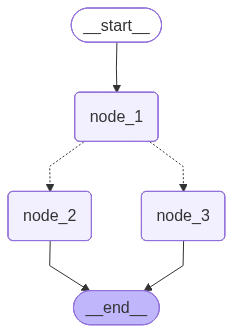

In [22]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
graph.invoke({"graph_state" : "Hi, this is Lance."})

---Node 1---
---Node 3---


{'graph_state': 'Hi, this is Lance. I am sad!'}

# Chain
* https://github.com/langchain-ai/langchain-academy/tree/main/module-1
    - https://github.com/langchain-ai/langchain-academy/blob/main/module-1/chain.ipynb

## Messages

In [34]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [35]:
messages

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Model'),
 HumanMessage(content="Yes, that's right.", additional_kwargs={}, response_metadata={}, name='Lance'),
 AIMessage(content='Great, what would you like to learn about.', additional_kwargs={}, response_metadata={}, name='Model'),
 HumanMessage(content='I want to learn about the best place to see Orcas in the US.', additional_kwargs={}, response_metadata={}, name='Lance')]

## Chat Models

In [36]:
llm = HuggingFaceEndpoint(
    repo_id="deepseek-ai/DeepSeek-R1-0528",
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
    provider="auto",  # let Hugging Face choose the best provider for you
)

hf_deepseek_model = ChatHuggingFace(llm=llm)

In [37]:
result = hf_deepseek_model.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [41]:
result.pretty_print()

================================== Ai Message ==================================

<think>
Okay, the user is asking about the best places to see orcas in the US. They mentioned they're researching ocean mammals, so this is a follow-up to that interest. 

Hmm, they specifically want US locations, so I should focus on domestic spots rather than international ones like Canada or Norway. The user seems excited about wildlife tourism, probably planning a trip. 

I recall the San Juan Islands in Washington are legendary for orca sightings, especially the Southern Resident pods. That's definitely the top recommendation. But I should also mention other good options since travel logistics vary—Alaska for more remote adventures, Monterey Bay for California-based travelers, and Oregon coast for seasonal migrations. 

Wait, should I warn about ethical concerns? Yes, absolutely. The user seems responsible since they're researching properly. I'll emphasize choosing ethical operators and respecting vi

In [42]:
result.response_metadata

{'token_usage': {'completion_tokens': 862,
  'prompt_tokens': 51,
  'total_tokens': 913},
 'model_name': 'deepseek-ai/DeepSeek-R1-0528',
 'system_fingerprint': '',
 'finish_reason': 'length',
 'logprobs': None}

## Tools

**ВНИМАНИЕ! В процессе обработки `llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])` LLM не вызывает самостоятельно функцию от аргументов. Она просто определяет, что есть функция, с помощью которой можно выполнить действие, которое запросил пользователь. LLM нам может определить какую функцию нам следует вызвать и с какими аргументами, чтобы удовлетворить запрос пользователя. Но саму функцию мы должны вызывать отдельно, прописав, отдельный функционал!!!**

Этот отдельный функционал мы будет строить в следующем разделе под названием Router. Как я понял, для вызова функции нам нужно будет создать отдельную ноду.

In [44]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = hf_deepseek_model.bind_tools([multiply])

In [45]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [54]:
tool_call.response_metadata, "===========================", tool_call.tool_calls, "===========================", tool_call.additional_kwargs['tool_calls']

({'token_usage': {'completion_tokens': 88,
   'prompt_tokens': 142,
   'total_tokens': 230},
  'model_name': 'deepseek-ai/DeepSeek-R1-0528',
  'system_fingerprint': '',
  'finish_reason': 'tool_calls',
  'logprobs': None},
 '===========================',
 [{'name': 'multiply',
   'args': {'a': 2, 'b': 3},
   'id': 'call_5u0dl6opwbbytw7zfiarpvyl',
   'type': 'tool_call'}],
 '===========================',
 [{'function': {'arguments': '{"a": 2, "b": 3}',
    'name': 'multiply',
    'description': None},
   'id': 'call_5u0dl6opwbbytw7zfiarpvyl',
   'type': 'function'}])

In [53]:
tool_call.additional_kwargs['tool_calls']

[{'function': {'arguments': '{"a": 2, "b": 3}',
   'name': 'multiply',
   'description': None},
  'id': 'call_5u0dl6opwbbytw7zfiarpvyl',
  'type': 'function'}]

In [48]:
tool_call.pretty_print()

================================== Ai Message ==================================

<think>
We are given a function called multiply that takes two integers a and b and returns their product.
 The user is asking for 2 multiplied by 3, so we can call the multiply function with a=2 and b=3.
</think>

I will calculate the product of 2 and 3 for you.
Tool Calls:
  multiply (call_5u0dl6opwbbytw7zfiarpvyl)
 Call ID: call_5u0dl6opwbbytw7zfiarpvyl
  Args:
    a: 2
    b: 3


## Using messages as state

* В [видео от LangChain Academy](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58238466-lesson-4-chain) на 3:20 автор показывает как добавлять к текущему состоянию новые сообщения, чтобы хранить всю историю сообщений. 
* В LangChain Docs есть отдельная заметка про [Overwrite](https://docs.langchain.com/oss/python/langgraph/graph-api#overwrite), чтобы перезаписывать состояние и про [Reducers](https://docs.langchain.com/oss/python/langgraph/graph-api#reducers), чтобы добавлять к текущему состоянию новую информацию.
* Эта информация мне нужна, чтобы наоборот сбрасывать контекст/состояние для каждого из агентов.

In [55]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers

Now, we have a minor problem!

As we discussed, each node will return a new value for our state key messages.

But, this new value will overwrite the prior messages value!

As our graph runs, we want to append messages to our messages state key.

We can [use reducer functions](https://docs.langchain.com/oss/python/langgraph/graph-api#reducers) to address this.

Reducers specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-built add_messages reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our messages key with the add_messages reducer function as metadata.

In [56]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [57]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='926ce875-4e4c-4b25-a376-09c57e6d1876'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='6205d3ea-5e50-47ce-bb2b-15f0d2f9109e'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='1e2b3dcb-7d97-4b3b-9943-faa83786582b')]

## Our graph

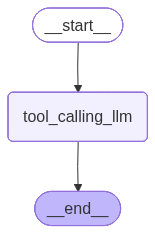

In [58]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [59]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

<think>
We are given a function to multiply two integers. The user has just said "Hello!". 
 There is no request to use the function in the user's message. 
 We should respond appropriately to the greeting and wait for further instructions.
</think>

Hello! How can I assist you today?


In [60]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================

<think>
We are given two numbers: 2 and 3. We are to multiply them.
 We have a function called "multiply" that takes two integers, a and b.
 We can call this function with a=2 and b=3.
</think>

I will multiply 2 and 3 for you.
Tool Calls:
  multiply (call_x4i9s0coywjct9mex6j1tja7)
 Call ID: call_x4i9s0coywjct9mex6j1tja7
  Args:
    a: 2
    b: 3


In [62]:
messages['messages']

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='78faae09-bc07-483f-8b9c-81129e424e78'),
 AIMessage(content='<think>\nWe are given two numbers: 2 and 3. We are to multiply them.\n We have a function called "multiply" that takes two integers, a and b.\n We can call this function with a=2 and b=3.\n</think>\n\nI will multiply 2 and 3 for you.', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply', 'description': None}, 'id': 'call_x4i9s0coywjct9mex6j1tja7', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 140, 'total_tokens': 228}, 'model_name': 'deepseek-ai/DeepSeek-R1-0528', 'system_fingerprint': '', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b8a49-4c60-7e02-a46c-c528ac67a6fb-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_x4i9s0coywjct9mex6j1tja7', 'type': 'tool_call'}], usage_metadata={'input_tokens

# Router
* https://github.com/langchain-ai/langchain-academy/tree/main/module-1
    - https://github.com/langchain-ai/langchain-academy/blob/main/module-1/router.ipynb

In [66]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

In [67]:
llm = HuggingFaceEndpoint(
    repo_id="deepseek-ai/DeepSeek-R1-0528",
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
    provider="auto",  # let Hugging Face choose the best provider for you
)

hf_deepseek_model = ChatHuggingFace(llm=llm)
llm_with_tools = hf_deepseek_model.bind_tools([multiply])

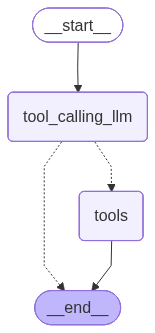

In [68]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [71]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello, bro! How are you?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, bro! How are you?
================================== Ai Message ==================================

<think>
We are given a list of tools, but the user's greeting does not require using any tool.
 The user said: "Hello, bro! How are you?" which is a greeting and does not require multiplication.
 Therefore, we should directly reply without any tool calls.
</think>


Hey there! I'm doing great, thanks for asking.  😊 How about you? What can I help you with today?


In [70]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello, what is 5 multiplied by 24?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, what is 5 multiplied by 24?
================================== Ai Message ==================================

<think>
We are given the function multiply that takes two integers a and b and returns their product.
 The user is asking for 5 multiplied by 24.
 So, we will call the multiply function with a=5 and b=24.
</think>

I will calculate that for you using the multiply function.
Tool Calls:
  multiply (call_3gdowhwcb7ygnt6qua6hjotw)
 Call ID: call_3gdowhwcb7ygnt6qua6hjotw
  Args:
    a: 5
    b: 24
================================= Tool Message =================================
Name: multiply

120


# Agent
* https://github.com/langchain-ai/langchain-academy/tree/main/module-1
    - https://github.com/langchain-ai/langchain-academy/blob/main/module-1/agent.ipynb

* В этой главе демонстрируют и реализуют архитектуру агента под названием ReAct. 
* По сути бейзлайн моего проекта - это и есть ReAct архитектура.
* В этой главе подробно объясняется как настроить логирование в LangSmith. Ничего сложного. Нужно занести в os.environment API-ключ и название проекта для LangSmith. И проект создастся автоматически и автоматически начнется логирование. Также показывается что именно интересного можно смотреть в LangSmith.

In [4]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

llm = HuggingFaceEndpoint(
    repo_id="deepseek-ai/DeepSeek-R1-0528",
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
    provider="auto",  # let Hugging Face choose the best provider for you
)

hf_deepseek_model = ChatHuggingFace(llm=llm)

# For this ipynb we set parallel tool calling to false as math generally is done sequentially, and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!
llm_with_tools = hf_deepseek_model.bind_tools(tools)

In [5]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

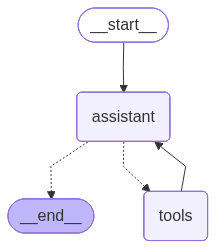

In [6]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [7]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

In [8]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================

<think>
We are going to break down the problem step by step.
 Step 1: Add 3 and 4.
 Step 2: Take the result from step 1 and multiply it by 2.
 Step 3: Take the result from step 2 and divide it by 5.

 We can use the provided functions: add, multiply, and divide.

 Let's start by adding 3 and 4.
</think>

I'll help you solve this step by step. First, I'll add 3 and 4.
Tool Calls:
  add (call_p4o1rw3sza2ieno6juxsb2f2)
 Call ID: call_p4o1rw3sza2ieno6juxsb2f2
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

<think>
Now we have the result from the addition: 7.
 Next step: multiply the output (7) by 2.
</think>

Now I'l

# Agent with memory
* https://github.com/langchain-ai/langchain-academy/tree/main/module-1
    - https://github.com/langchain-ai/langchain-academy/blob/main/module-1/agent-memory.ipynb
* В этом уроке вводится новый механизм: механизм памяти. Он реализуется за счет `from langgraph.checkpoint.memory import MemorySaver`. При компиляции графа необходимо указать `builder.compile(checkpointer=memory)`
* Надо проверить гипотезу. В предыдущем разделе мы написали одно сообщение `messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]` и подали его на исполнение. Агент автономно с ним работал и выплюнул ответ. Однако если бы в этого же агента далее снова засунули бы какое-нибудь сообщение и исполнили бы его, то агент бы не помнил предыдущих состояний и не знал бы ничего о действиях предыдущего агента, потому что агент после первого вызова завершил свою работу (пришел в ноду `END`) и после этого сбросил состояние. Когда мы подаем агенту на исполнение второе сообщение, то он начинает работу с нуля и поэтому у него нулевое состояние. **ВРОДЕ ЗВУЧИТ ЛОГИЧНО, НАДО ПОПРОБОВАТЬ!!!!**

In [9]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]

llm = HuggingFaceEndpoint(
    repo_id="deepseek-ai/DeepSeek-R1-0528",
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
    provider="auto",  # let Hugging Face choose the best provider for you
)

hf_deepseek_model = ChatHuggingFace(llm=llm)

# For this ipynb we set parallel tool calling to false as math generally is done sequentially, and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!
llm_with_tools = hf_deepseek_model.bind_tools(tools)

In [10]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

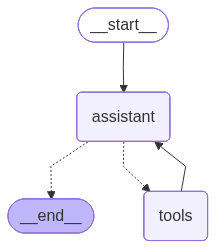

In [11]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## Memory

In [12]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================

<think>
We are given the task to add 3 and 4.
 We have an 'add' function that takes two integers and returns their sum.
 Let's call the add function with a=3 and b=4.
</think>

I'll add 3 and 4 for you.
Tool Calls:
  add (call_z7jpg5801eelyyc5bktbp8w1)
 Call ID: call_z7jpg5801eelyyc5bktbp8w1
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

<think>
The tool returned the result of adding 3 and 4, which is 7.
 We can now present the answer to the user.
</think>

The sum of 3 and 4 is **7**.


In [13]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

<think>
We are given a set of inputs. However, the user's instruction is "Multiply that by 2." 
 But note: the problem does not specify what "that" is. 
 Since we are not provided with the previous context, we must assume that the user is referring to a result from a previous step or an initial input.

 However, looking at the problem statement, we are only told: "You are a helpful assistant tasked with performing arithmetic on a set of inputs." 
 And then the user says: "Multiply that by 2."

 Without knowing what "that" is, we cannot proceed. 

 But note: the example function calls provided are for two integers. 

 Therefore, we must clarify or assume that the user intended to provide two numbers? 

 Alternatively, the problem might be that the user is continuing a conversation. Since this is the first 

## Try using Memory

In [15]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

In [ ]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================

<think>
We are given a task to add 3 and 4.
 There is a function called "add" that takes two integers, a and b, and returns their sum.
 We need to call the "add" function with a=3 and b=4.
 Since we are only making one function call, we output in the single tool call format.
</think>
Tool Calls:
  add (b4ca0a8434df4497bbdaf4d2e06c0090)
 Call ID: b4ca0a8434df4497bbdaf4d2e06c0090
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

<think>
We are adding 3 and 4. The result is 7.
 Since the task is complete, we can output the result.
</think>

The result of adding 3 and 4 is **7**.


In [17]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================

<think>
We are given a task to add 3 and 4.
 There is a function called "add" that takes two integers, a and b, and returns their sum.
 We need to call the "add" function with a=3 and b=4.
 Since we are only making one function call, we output in the single tool call format.
</think>
Tool Calls:
  add (b4ca0a8434df4497bbdaf4d2e06c0090)
 Call ID: b4ca0a8434df4497bbdaf4d2e06c0090
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

<think>
We are adding 3 and 4. The result is 7.
 Since the task is complete, we can output the result.
</think>

The result of adding 3 and 4 is **7**.
================================ Human Message =================================

Multip